In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.linalg import dft
from tsvd import *
from scipy.linalg import block_diag


In [2]:
np.random.seed(0)
random.seed(0)
n1 = 50
n3 = 20
r = 5
m = n1 * n3

In [3]:
X = Tensor(np.random.randn(n1,r,n3))
Ureal = tsvd(X,full=False)[0]
Ubar = np.fft.fft(Ureal.array(), axis=2)

# U = block_diag(Ubar[:,:,0],Ubar[:,:,1],Ubar[:,:,2],Ubar[:,:,3],Ubar[:,:,4])

U = block_diag(Ubar[:,:,0],Ubar[:,:,1],Ubar[:,:,2],Ubar[:,:,3],Ubar[:,:,4],Ubar[:,:,5],Ubar[:,:,6],Ubar[:,:,7],
               Ubar[:,:,8],Ubar[:,:,9],Ubar[:,:,10],Ubar[:,:,11],Ubar[:,:,12],Ubar[:,:,13],Ubar[:,:,14],Ubar[:,:,15],Ubar[:,:,16],Ubar[:,:,17],
               Ubar[:,:,18],Ubar[:,:,19])

In [4]:
F = 1 / np.sqrt(n3) * dft(n3)
# U = F @ Ureal
Finv = F.conj()
Finv = np.kron(Finv,np.eye(n1))
# D = np.diag((-1)**random.randrange(2) *np.random.rand(m) + (-1)**random.randrange(2)*1j* np.random.rand(m))
D = np.eye(m)

In [5]:
FDU = (Finv @ D @ U)
coherence = np.max(np.linalg.norm(FDU,axis=1)**2)
min_coh = (n3*r) / (n1*n3)
print('FDU coherence: {:5f}'.format(coherence))
print('Minimum coherence: {:5f}'.format(min_coh))

FDU coherence: 0.120710
Minimum coherence: 0.100000


In [6]:
### Get taus and kappas with sampling % sweep

larray = np.arange(int(0.1*m),0.95*m)
kappas = []

i = 0
for l in larray:
    kappa_log = []
    for k in range(0,20):
#         idx = np.random.choice(m,l)
        rho = 1 - l / m
        mask = np.random.rand(m)
        mask[mask > rho] = 1
        mask[mask <= rho] = 0
        mask = mask.astype(int)
        idx = np.where(mask > 0)[0]
        SFDU = FDU[idx,:]
        kappa_log.append(np.linalg.cond(SFDU)**2)
    kappas.append(np.mean(kappa_log))
#     tau = C * np.sqrt(m*max(r*n3,np.log(m))*np.log(l)/l)
#     tau = C * np.sqrt(m*min_coh*np.log(l)/l)
#     taus[i] = tau
    i += 1

In [7]:
taus = np.zeros(len(larray))
# C = 0.035  #r = 2
# C = 0.0015  #r = 9
# C = 0.0001  #n1 = 100
# C = 0.00037    #n1 = 50
# C = 0.00037
C = 0.0009 * np.sqrt(m)

eps = 1e-7
delta = 0.05

i = 0
for l in larray:
    tau = C * np.sqrt(max(r*n3,np.log(m))*np.log(l)/l)
#     tau = C * np.sqrt(m*coherence*np.log(l)/l)
#     tau = C * np.sqrt(m*min_coh*np.log(l)/l)
    taus[i] = tau
    i += 1

In [8]:
### Get the theory upper bounds on CGD iter
cgd_iters = np.ceil(0.5*np.sqrt(kappas)*np.log(2/eps))
cgd_iters_ub = np.ceil(0.5*np.sqrt((1 + taus/delta)/(1 - taus/delta)) * np.log(2/eps))

/Users/kgilman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
### IHS bound
rho_ihs = np.zeros(len(larray))
i = 0
C0 = 0.32
for l in larray:
    rho_ihs[i] = 2*C0*np.sqrt(r*n3 / l * np.log(1/delta))
    i += 1

cgd_iters_ihs = 0.5 * (1 / (1 - rho_ihs)) * np.log(2 / eps)


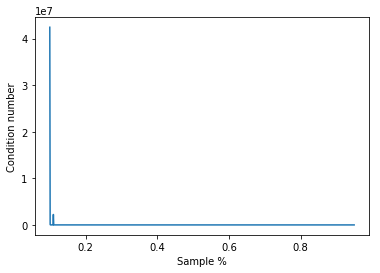

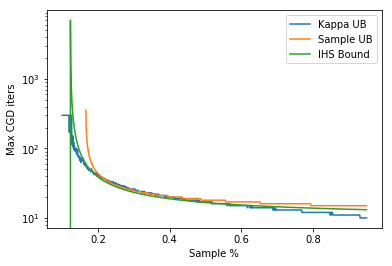

In [10]:
plt.plot(larray/m,kappas)
plt.xlabel('Sample %')
plt.ylabel('Condition number')
plt.show()

plt.semilogy(larray/m, np.clip(cgd_iters,a_min=0,a_max=300),
         larray/m,cgd_iters_ub,
         larray/m, cgd_iters_ihs)
plt.xlabel('Sample %')
plt.ylabel('Max CGD iters')
plt.legend(['Kappa UB','Sample UB','IHS Bound'])
plt.show()

In [11]:
### Empirical with TOUCAN (with U estimation)
np.random.seed(0)
# P = tsvd(Tensor(np.random.randn(n1, n1, n3)))[0]
# P = Tensor(np.random.randn(n1,n1,n3))
Utrue = Ureal
n2 = 200
W = Tensor(np.random.randn(r, n2, n3))
L = Utrue * W

Lfrob = tfrobnorm(L)

rho_array = np.arange(0.1,1,step=0.05)
# rho_array = [0.1]
print(rho_array)
nrmse_log = []
cgd_log = []
tube = False

U0 = tsvd(Tensor(np.random.randn(n1, r, n3)),full=False)[0]
U0 = Tensor(U0.array()[:, :r, :])
    
for rho in rho_array:
    print('Sampling ' + np.str(rho * 100) + '% entries...')

    mask = np.random.rand(n1, n2, n3)
    mask[mask > 1 - rho] = 1
    mask[mask <= 1 - rho] = 0
    mask = mask.astype(int)

    Y = Tensor(L.array() * mask)

    fun = lambda X,k: [0,tfrobnorm(X - L) / Lfrob]
    Lhat, U, stats_toucan, tElapsed = toucan(Y,mask,r,tube=tube,outer=5,mode="online",tol=eps,step=None,cgiter=None,cgtol=eps,fun=fun,
           randomOrder=False,verbose=False, U0=U0)

    nrmse = tfrobnorm(Lhat - L) / Lfrob
    nrmse_log.append(nrmse)
    cgd_log.append(np.mean(stats_toucan[:,2]))



[0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75
 0.8  0.85 0.9  0.95]
Sampling 10.0% entries...
Sampling 15.000000000000002% entries...
Sampling 20.000000000000004% entries...
Sampling 25.000000000000007% entries...
Sampling 30.000000000000004% entries...
Sampling 35.00000000000001% entries...
Sampling 40.000000000000014% entries...
Sampling 45.00000000000001% entries...
Sampling 50.000000000000014% entries...
Sampling 55.000000000000014% entries...
Sampling 60.00000000000002% entries...
Sampling 65.00000000000001% entries...
Sampling 70.00000000000001% entries...
Sampling 75.00000000000003% entries...
Sampling 80.00000000000001% entries...
Sampling 85.00000000000001% entries...
Sampling 90.00000000000003% entries...
Sampling 95.00000000000003% entries...


In [12]:
# ### Empirical with TOUCAN (with U estimation)
# np.random.seed(0)
# # P = tsvd(Tensor(np.random.randn(n1, n1, n3)))[0]
# # P = Tensor(np.random.randn(n1,n1,n3))
# Utrue = Ureal
# n2 = 1
# max_n2 = 1000
# # W = Tensor(np.random.randn(r, n2, n3))
# # L = Utrue * W

# rho_array = np.arange(0.1,0.95,step=0.05)
# # rho_array = [0.1]
# print(rho_array)
# nrmse_log = []
# cgd_log = []
# tube = False

# UUT = Utrue * Utrue.T()
# UUT_norm = tfrobnorm(Utrue * Utrue.T())
# fun = lambda Uhat: tfrobnorm(Uhat * Uhat.T() - UUT) / UUT_norm
# U0 = tsvd(Tensor(np.random.randn(n1, r, n3)),full=False)[0]
# U0 = Tensor(U0.array()[:, :r, :])
    
# for rho in rho_array:
#     print(rho)
#     Uhat = Tensor(U0.array().copy())
    
#     cgd_inner_log = []
#     itr = 0
#     for inner in range(0,max_n2):

#         mask = np.random.rand(n1, n2, n3)
#         mask[mask > rho] = 1
#         mask[mask <= rho] = 0
#         mask = mask.astype(int)

#         W = Tensor(np.random.randn(r,1,n3))
#         L = Utrue * W
#         Y = Tensor(L.array() * mask)
        
#         Uhat, w, cg_iters = toucan_stream(Y, mask[:,0,:], Uhat, step=None, cgiter = None, cgtol = eps)
#         cgd_inner_log.append(cg_iters)
#         itr += 1
#         if(fun(Uhat) < eps):
#             break
            
#     nrmse_log.append(itr)
#     cgd_log.append(np.mean(cgd_inner_log))


In [13]:
# ### Empirical with TOUCAN (with no U estimation)
# np.random.seed(0)
# # P = tsvd(Tensor(np.random.randn(n1, n1, n3)))[0]
# # P = Tensor(np.random.randn(n1,n1,n3))
# Utrue = Ureal
# n2 = 200
# W = Tensor(np.random.randn(r, n2, n3))
# L = Utrue * W

# # rho_array = np.arange(0.1,1 - (r*n3)/(n1*n3),step=0.05)
# rho_array = np.arange(0.1,0.95,step=0.05)
# nrmse_log_noU = []
# cgd_log_noU = []
# for rho in rho_array:

#     tube = False
#     # rho = 0.5  # percentage of missing entries
#     # rho = 1 - r*n3 / (n1*n3)
#     print(rho)

#     if (tube is False):
#         mask = np.random.rand(n1, n2, n3)
#         mask[mask > rho] = 1
#         mask[mask <= rho] = 0
#         mask = mask.astype(int)
#     else:
#         mask = np.random.rand(n1, n2)
#         mask[mask > rho] = 1
#         mask[mask <= rho] = 0
#         mask = mask.astype(int)
#         mask = np.repeat(mask[:, :, np.newaxis], n3, axis=2)

#     sig = 0
#     L += Tensor(sig * np.random.randn(n1, n2, n3))
#     Lfrob = tfrobnorm(L)

#     Y = Tensor(L.array() * mask)

#     fun = lambda X,k: [0, tfrobnorm_array(X - L.array()[:,k,:]) / tfrobnorm_array(L.array()[:,k,:])]
#     Y_hat_toucan, U, stats_toucan, tElapsed_toucan = toucan(Y,mask,rank=r,tube=tube,outer=5,mode='online',cgiter = None,cgtol=eps,
#                                                             fun=fun,
#                                                          randomOrder=False,verbose=False,U0=Utrue)

#     toucan_nrmse_noU = tfrobnorm(Y_hat_toucan - L) / Lfrob
#     # print('TOUCAN Time: {:4f}'.format(tElapsed_toucan))
#     # print('TOUCAN NRMSE: {:4f}'.format(toucan_nrmse))

#     # nrmse_toucan = stats_toucan[:,1]
#     cgiter_toucan_noU = stats_toucan[:,2]
#     # times_toucan = stats_toucan[:,-1]

#     # plt.semilogy(nrmse_toucan)
#     # plt.title('TOUCAN: Recovered Tensor NRMSE')
#     # plt.xlabel('Iteration')
#     # plt.show()
#     #
#     # plt.scatter(np.arange(0,len(cgiter_toucan[1:])),cgiter_toucan[1:])
#     # plt.show()

#     nrmse_log_noU.append(toucan_nrmse_noU)
#     cgd_log_noU.append(np.mean(cgiter_toucan_noU))

In [20]:
den = n1*n2*n3*np.array(rho_array)
num = n1*n3*r + r*n2*n3 - r**2 * n3
# print(num)
# print(den)
# print(num/den)
print(larray/m)
print(rho_array)


[0.1   0.101 0.102 0.103 0.104 0.105 0.106 0.107 0.108 0.109 0.11  0.111
 0.112 0.113 0.114 0.115 0.116 0.117 0.118 0.119 0.12  0.121 0.122 0.123
 0.124 0.125 0.126 0.127 0.128 0.129 0.13  0.131 0.132 0.133 0.134 0.135
 0.136 0.137 0.138 0.139 0.14  0.141 0.142 0.143 0.144 0.145 0.146 0.147
 0.148 0.149 0.15  0.151 0.152 0.153 0.154 0.155 0.156 0.157 0.158 0.159
 0.16  0.161 0.162 0.163 0.164 0.165 0.166 0.167 0.168 0.169 0.17  0.171
 0.172 0.173 0.174 0.175 0.176 0.177 0.178 0.179 0.18  0.181 0.182 0.183
 0.184 0.185 0.186 0.187 0.188 0.189 0.19  0.191 0.192 0.193 0.194 0.195
 0.196 0.197 0.198 0.199 0.2   0.201 0.202 0.203 0.204 0.205 0.206 0.207
 0.208 0.209 0.21  0.211 0.212 0.213 0.214 0.215 0.216 0.217 0.218 0.219
 0.22  0.221 0.222 0.223 0.224 0.225 0.226 0.227 0.228 0.229 0.23  0.231
 0.232 0.233 0.234 0.235 0.236 0.237 0.238 0.239 0.24  0.241 0.242 0.243
 0.244 0.245 0.246 0.247 0.248 0.249 0.25  0.251 0.252 0.253 0.254 0.255
 0.256 0.257 0.258 0.259 0.26  0.261 0.262 0.263 0.

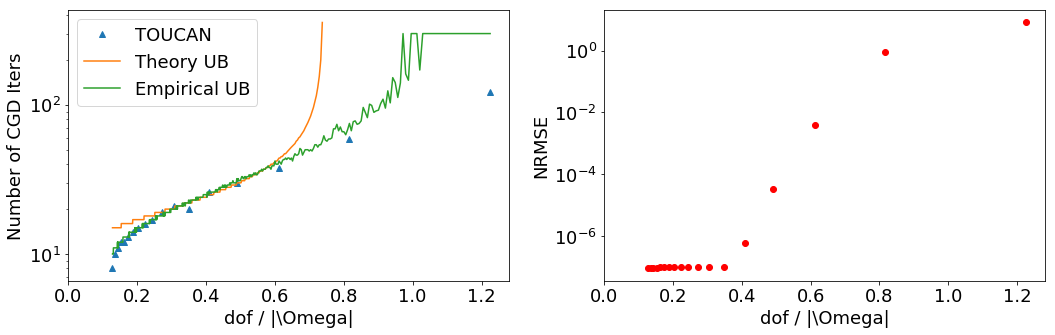

In [21]:
plt.figure(figsize=(15,5),tight_layout=True)
plt.subplot(1,2,1)
plt.xlabel('dof / |\Omega|')
plt.ylabel('Number of CGD Iters')
plt.semilogy(num/den,np.ceil(cgd_log),'^',label='TOUCAN')
plt.semilogy(num/(larray*n2),(cgd_iters_ub),label='Theory UB')
plt.semilogy(num/(larray*n2),(np.clip(cgd_iters,a_min=0,a_max=300)),label='Empirical UB')
plt.legend()
# plt.xticks(np.arange(0, 1, step=0.1))
plt.xticks(np.arange(0,np.max(num/den),step=0.2))

plt.subplot(1,2,2)
plt.ylabel('NRMSE') 
plt.xlabel('dof / |\Omega|')
plt.semilogy(num/den,nrmse_log,'ro')
plt.xticks(np.arange(0,np.max(num/den),step=0.2))

# fig.tight_layout()  # otherwise the right y-label is slightly clipped
name = 'cgd_iter_vs_sample' + str(r) + '-' + str(n1) + '-' + str(n3) + '.eps'
plt.rcParams.update({'font.size': 18})
plt.savefig(name)
plt.show()

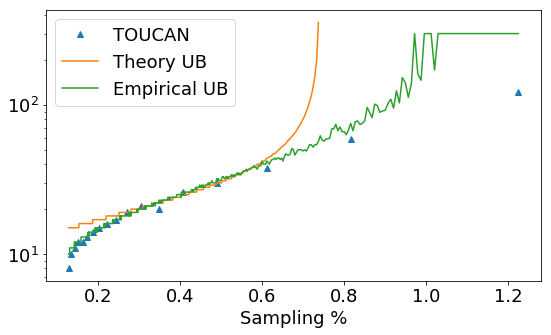

In [19]:
den = n1*n2*n3*np.array(1 - rho_array)
num = n1*n3*r + r*n2*n3 - r**2 * n3

plt.figure(figsize=(8,5),tight_layout=True)
plt.semilogy(num / (n1*n2*n3*(rho_array)),(np.ceil(cgd_log)),'^',label='TOUCAN')
plt.semilogy(num / (n1*n2*n3*(larray/m)),((cgd_iters_ub)), label='Theory UB')
plt.semilogy(num / (n1*n2*n3*(larray/m)),(np.clip(cgd_iters,a_min=0,a_max=300)),label='Empirical UB')
plt.legend()
plt.xlabel('Sampling %')
plt.show()

In [17]:
print(num / (n1*n2*n3*(rho_array)))
print(cgd_log)

[1.225      0.81666667 0.6125     0.49       0.40833333 0.35
 0.30625    0.27222222 0.245      0.22272727 0.20416667 0.18846154
 0.175      0.16333333 0.153125   0.14411765 0.13611111 0.12894737]
[120.9020979020979, 58.246753246753244, 37.094905094905094, 29.35764235764236, 25.167832167832167, 19.83916083916084, 20.00782268578879, 18.28767123287671, 16.905723905723907, 15.706642066420665, 14.72055888223553, 13.701716738197424, 12.78132118451025, 11.932692307692308, 11.024752475247524, 10.11948051948052, 9.054794520547945, 7.936599423631124]
